# Projet d'Analyse de Donn√©es : Pr√©diction du prix de Airbnb

## Introduction

Ce projet a pour objectif d'exposer une d√©marche compl√®te sur un jeu de donn√©es allant de l'exploration √† la mod√©lisation de donn√©es r√©elles.

Le projet consiste √† pr√©dire le **logarithme du prix** d'un logement Airbnb √† partir de ses caract√©ristiques donn√©es depuis un document csv.  
Cela implique plusieurs √©tapes : 
- **Explorer et comprendre** les donn√©es disponibles,
- **Nettoyer** et **pr√©traiter** ces donn√©es pour les rendre exploitables,
- **Cr√©er de nouvelles caract√©ristiques** pertinentes pour la pr√©diction,
- **Construire et √©valuer des mod√®les pr√©dictifs**.

Nous allons suivre une d√©marche rigoureuse, en expliquant **pourquoi** nous r√©alisons chaque √©tape, **comment** elle est mise en ≈ìuvre, et **quelles conclusions** nous pouvons en tirer pour chaque √©.

Notre objectif n'est pas seulement d'obtenir la meilleure performance possible, mais surtout de montrer une analyse critique et structur√©e de notre approche.

---


## Exploration des donn√©es initiales 

In [4]:
# Importation des biblioth√®ques n√©cessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioth√®que de la partie mod√©lisation 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.decomposition import PCA

#### Commen√ßons par charger le jeu de donn√©es

In [6]:
Donnee_Train = pd.read_csv("airbnb_train.csv")

In [7]:
dimensions = Donnee_Train.shape
types = Donnee_Train.dtypes.value_counts()

print("Dimensions :", dimensions)
print("\nTypes:\n", types)

Dimensions : (22234, 28)

Types:
 object     17
float64     7
int64       3
bool        1
Name: count, dtype: int64


On a donc 17 donn√©es qualitatives, 10 quantitatives et 1 bool√©enne. 

### Pr√©sentation rapide du dataset

Nous disposons de **22234 enregistrements** et de **28 variables** d√©crivant les logements.

Avant de pouvoir effectuer une pr√©diction fiable, il est n√©cessaire de comprendre la nature de ces donn√©es :
- Quels types de variables sont pr√©sentes (quantitatives, qualitatives) ?
- Si il y a des valeurs manquantes ?
- Quelles sont les variables qui semblent les plus li√©es au prix ?
  
### Valeurs manquantes
Nous allons d√©sormais regarder si il y a des valeurs manquantes dans nos donn√©es.

Cela permet d‚Äôidentifier :
- Les colonnes probl√©matiques
- La proportion d‚Äôinformations absentes
- Les strat√©gies √† envisager lors du preporcessing.

Nous allons donc visualiser quelles colonnes contiennent des donn√©es manquantes et √† quelle fr√©quence afin de pouvoir voir si il y a des donn√©es √† corriger pour le compl√©ter par la suite.

In [10]:
manquantes = Donnee_Train.isnull().sum()
manquante_p = (manquantes / len(Donnee_Train) * 100)


manquante_f = manquante_p[manquante_p > 0].sort_values(ascending=False)

manquante_data = pd.DataFrame({
    'Colonne': manquante_f.index,
    'Pourcentage de valeurs manquantes': manquante_f.values.round(1)
})

print(manquante_data)

                   Colonne  Pourcentage de valeurs manquantes
0       host_response_rate                               24.6
1     review_scores_rating                               22.4
2             first_review                               21.3
3              last_review                               21.2
4            neighbourhood                                9.4
5                  zipcode                                1.4
6     host_has_profile_pic                                0.3
7   host_identity_verified                                0.3
8               host_since                                0.3
9                bathrooms                                0.2
10                    beds                                0.2
11                bedrooms                                0.1


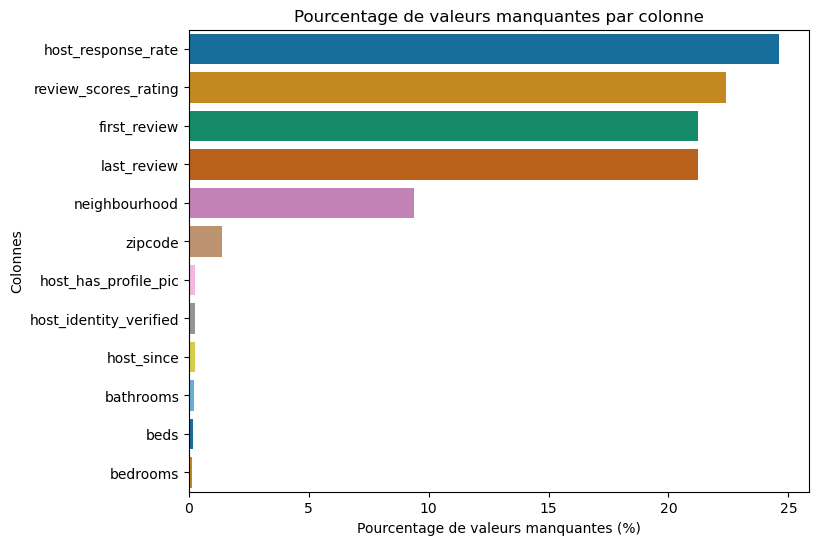

In [68]:
# calcul des valeurs manquantes en pourcentage
valeurs_manquantes = Donnee_Train.isnull().sum() / len(Donnee_Train) * 100

# il faut que on garde que les colonnes avec des valeurs manquantes
valeurs_manquantes = valeurs_manquantes[valeurs_manquantes > 0].sort_values(ascending=False)

#print(valeurs_manquantes)

plt.figure(figsize=(8, 6))
sns.barplot(x=valeurs_manquantes, y=valeurs_manquantes.index, hue=valeurs_manquantes.index,dodge=False, palette="colorblind", legend=False)
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.ylabel('Colonnes')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.show()

### Observations

En regardant les valeurs manquantes, on remarque que certaines colonnes comme `host_response_rate`, `review_scores_rating`, ou encore `first_review` et `last_review` ont plus de 20‚ÄØ% de donn√©es absentes. D'autres colonnes comme `neighbourhood` ou `zipcode` sont √©galement concern√©es mais dans une moindre mesure.

Plut√¥t que de supprimer directement ces colonnes et risquer de perdre des informations potentiellement utiles pour la pr√©diction, nous comptons les conserver en appliquant des strat√©gies adapt√©es que nous avons trouv√©es sur internet ou en cherchant dans des cours.  
Par exemple, nous pourrons utiliser **l'imputation par la moyenne** ou **la m√©diane** pour les variables num√©riques comme les `notes`, remplacer certaines dates manquantes par une valeur sp√©ciale, ou encore cr√©er de nouvelles variables, comme l'**anciennet√© d‚Äôune annonce** √† partir de `host_since`.

Concernant les colonnes num√©riques telles que `bathrooms`, `bedrooms` ou `beds`, le pourcentage de donn√©es manquantes est tr√®s faible, ce qui nous permettra de les compl√©ter facilement avec des **valeurs centrales** sans trop alt√©rer la qualit√© du dataset.

Globalement, le dataset est relativement propre et nous allons pouvoir exploiter la majorit√© des informations disponibles sans avoir besoin d'inventer ou de remplir massivement avec des "fausses" valeurs, ce qui est un point positif pour la suite de l‚Äôanalyse.


## Visualisation de la variable cible

Avant de passer aux pr√©dictions, on a commenc√© par jeter un ≈ìil √† la variable qu‚Äôon cherche √† pr√©dire : `log_price`.  
Comme son nom l‚Äôindique, il s‚Äôagit du **logarithme du prix** des logements. Cette transformation est souvent utilis√©e pour r√©duire l‚Äôeffet des valeurs extr√™mes (les logements tr√®s chers, par exemple) et pour rendre la distribution plus "normale", ce qui est souvent pr√©f√©rable pour entra√Æner des mod√®les de r√©gression.

L‚Äôid√©e ici, c‚Äôest de voir √† quoi ressemble sa distribution et surtout voir si l‚Äôutilisation du log a bien permis de lisser les donn√©es.

C‚Äôest une √©tape importante car cela nous donne une premi√®re id√©e de la r√©partition des prix et de comment nos futurs mod√®les risquent de se comporter.

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(Donnee_Train['log_price'], bins=50, kde=True, color='pink')
plt.title('Distribution de la variable cible : log_price')
plt.xlabel('log_price')
plt.ylabel('Fr√©quence')
plt.show()

La distribution du logarithme du prix pr√©sente une forme proche d'une loi normale, centr√©e entre 4.5 et 5.  
Cette r√©partition des prix est raisonnable et ne pr√©sente rien d'aberrant.  
Les diff√©rents pics de fr√©quence visibles sur l‚Äôhistogramme traduisent une certaine "naturalit√©" dans la distribution des prix, sans anomalie majeure.

In [15]:
Donnee_Train['log_price'].describe()

count    22234.000000
mean         4.783481
std          0.718758
min          2.302585
25%          4.317488
50%          4.700480
75%          5.220356
max          7.600402
Name: log_price, dtype: float64

La variable `log_price` correspond au logarithme du prix des logements. Quand on regarde sa distribution, elle est plut√¥t bien r√©partie et assez sym√©trique.

En moyenne, le `log_price` tourne autour de **4.78**, ce qui correspond √† un prix d‚Äôenviron **120 ‚Ç¨**.  
Les valeurs s'√©tendent entre des extr√™mes allant de **2.30** (soit environ **10 ‚Ç¨**) jusqu‚Äô√† **7.60** (environ **2000 ‚Ç¨**).

Nous remarquons aussi que la moiti√© des logements ont un prix en dessous de **4.70** en log, ce qui correspond √† moins de **110 ‚Ç¨**.  
On observe donc une m√©diane l√©g√®rement inf√©rieure √† la moyenne.

## Variables numeriques et variable cible, que pouvons nous dire? 

Pour d√©buter r√©ellement l'exploration des donn√©es nous allons tout d'abord tracer une heat map de correlation entre les donn√©es quantitatives car elles n'ont pas besoin d'√™tre traiter. Ce premier jet sur le jeu va permettre de r√©vel√© une coralation ou non entre les donn√©e. Elle est tr√®s utile et intuitive √† lire.

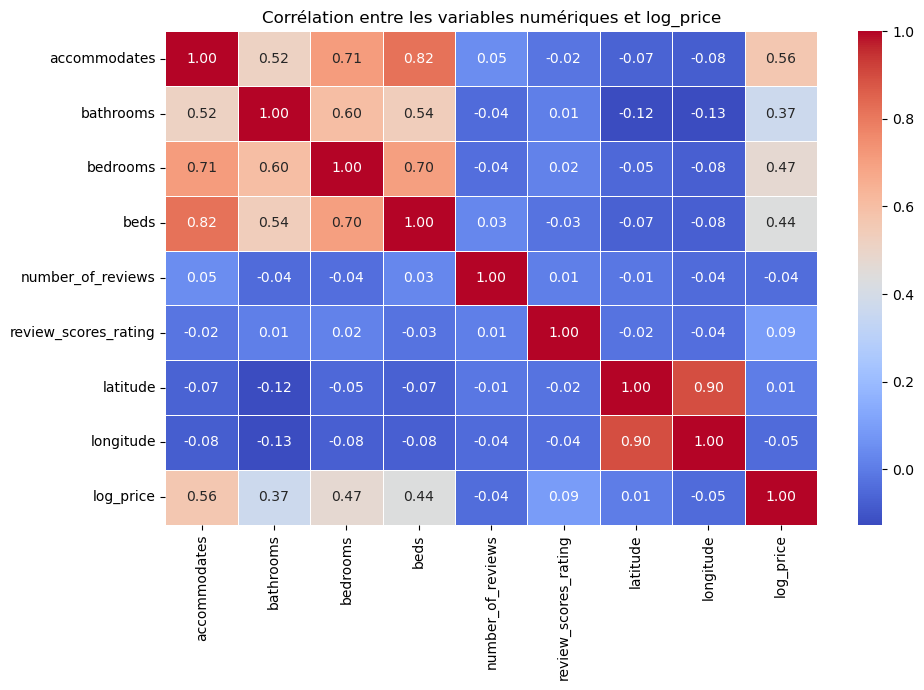

In [20]:
colonnes_numeriques = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
                       'number_of_reviews', 'review_scores_rating', 
                       'latitude', 'longitude', 'log_price']

matrice_correlation = Donnee_Train[colonnes_numeriques].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(matrice_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Corr√©lation entre les variables num√©riques et log_price")
plt.tight_layout()
plt.show()

On observe que certaines variables comme le nombre de personnes accept√©es (accommodates), les salles de bain, les chambres ou les lits sont bien corr√©l√©es avec le prix. Ce n‚Äôest pas trop surprenant : plus un logement est grand, plus il co√ªte cher. D‚Äôautres variables comme la latitude ou le nombre d‚Äôavis sont moins corr√©l√©es, mais on les garde au cas o√π elles apportent quelque chose plus tard lors du traitement des colonnes.

## Analyse du prix en fonction d'autres variables.

Nous allons donc nous interesser a la relation entre la variable `log_price` et d'autre varibles pour voir comment elles se repartissent et leur lien de proportionnalit√© si on peut si il est √©vident. Nous allons en premier lieu faire cette analyse avec les variable corr√©l√© aux prix comme `accommodates`, `bathrooms` et `beds`.

Commen√ßons avec `accommodates` !

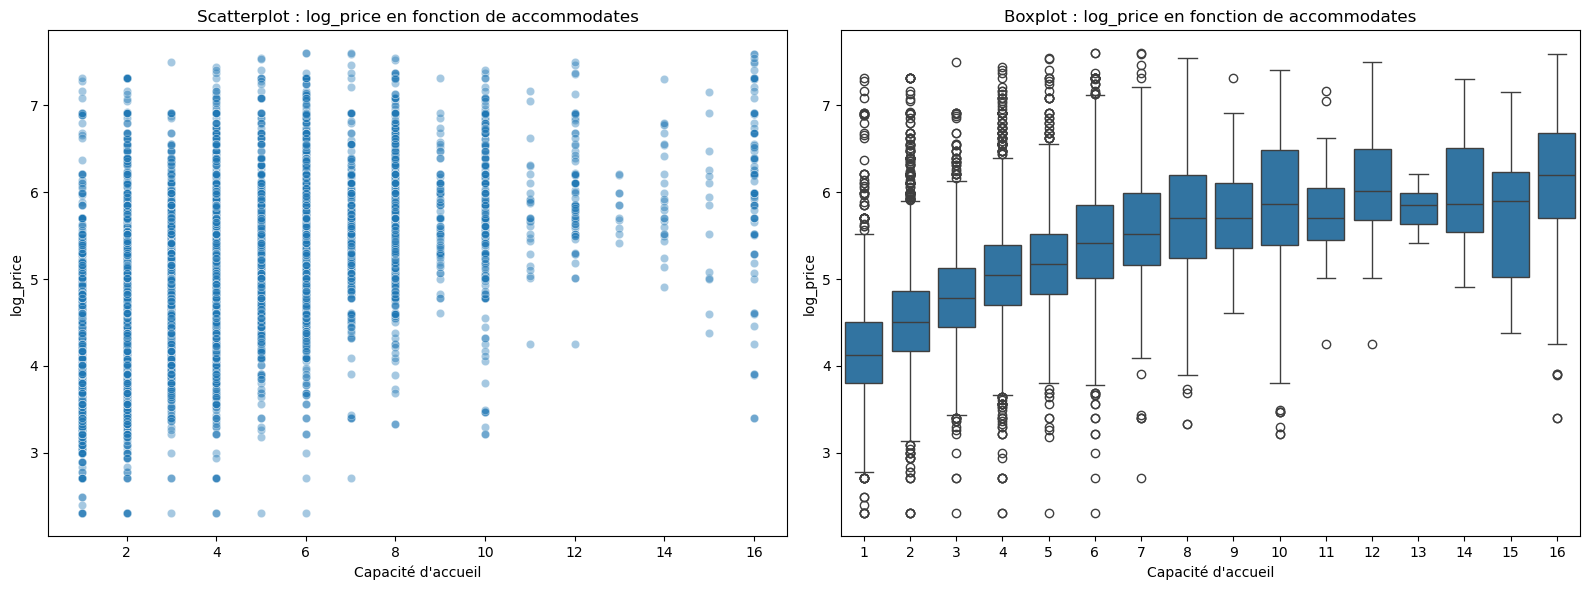

In [24]:
# Affichage c√¥te √† c√¥te : Scatterplot vs Boxplot

plt.figure(figsize=(16, 6))

# Scatterplot
plt.subplot(1, 2, 1)
sns.scatterplot(data=Donnee_Train, x='accommodates', y='log_price', alpha=0.4)
plt.title('Scatterplot : log_price en fonction de accommodates')
plt.xlabel('Capacit√© d\'accueil')
plt.ylabel('log_price')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='accommodates', y='log_price', data=Donnee_Train)
plt.title('Boxplot : log_price en fonction de accommodates')
plt.xlabel('Capacit√© d\'accueil')
plt.ylabel('log_price')

plt.tight_layout()
plt.show()

De part la difficult√© de lecture du scatterplot, nous avons prefer√© faire un diagram moustache (boxplot). Les boites "petites" indiquent un prix plus concentr√© par rapport a la capacit√© d'acceuil, alors que les boites "larges" indique des prix plus √©tal√©. On voit bien que plus un logement peut accueillir de monde, plus la moyenne prix a tendance √† augmenter et ceux de mani√®re exponentiel. Par contre, √† partir de 6-8 personnes, les prix deviennent plus dispers√©s. 

Nous allons maintenant regarder le lien entre `log_price` et la moyenne des avis `review_scores_rating`.

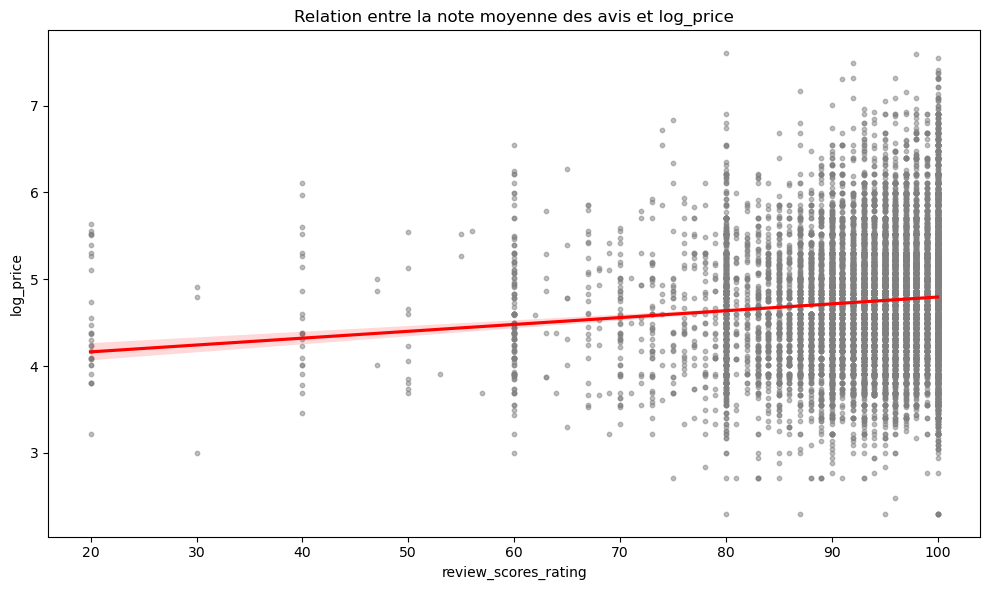

In [49]:
plt.figure(figsize=(10,6))
sns.regplot(data=Donnee_Train,x='review_scores_rating', y='log_price',
 scatter_kws={'alpha': 0.5, 'color': 'grey', 's': 10, 'marker': '.'},
    line_kws={'color': 'red'})

plt.title('Relation entre la note moyenne des avis et log_price')
#plt.xlabel('Note moyenne des avis')
#plt.ylabel('log_price')
plt.tight_layout()
plt.show()

 Nous avons decider d'affichr la courbe de la regression lineaire en plus des points car le scatterplot uniquement etait difficilement lisible.On observe une l√©g√®re tendance indiquant que les logements mieux not√©s sont en moyenne un peu plus chers, mais cela ne represente pas une augmentation tr√®s importante. En effet, la pente de la droite de r√©gression est **positive**, mais reste **tr√®s faible**, ce qui montre que la note moyenne des avis n'a pas un impact tr√®s important √† elle seule sur le prix.

Cela reste n√©anmoins une information int√©ressante √† garder, car il est possible qu‚Äôen combinaison avec d‚Äôautres variables (comme la localisation, le type de logement, etc.), cette note puisse jouer un r√¥le plus important.

Enfin, nous allons regarder le prix avec les deux variables du nombre de chambres `bedrooms` et de salles de bains `bathrooms`, on va donc repartir ces prix par des bulles plus ou moins grosses.

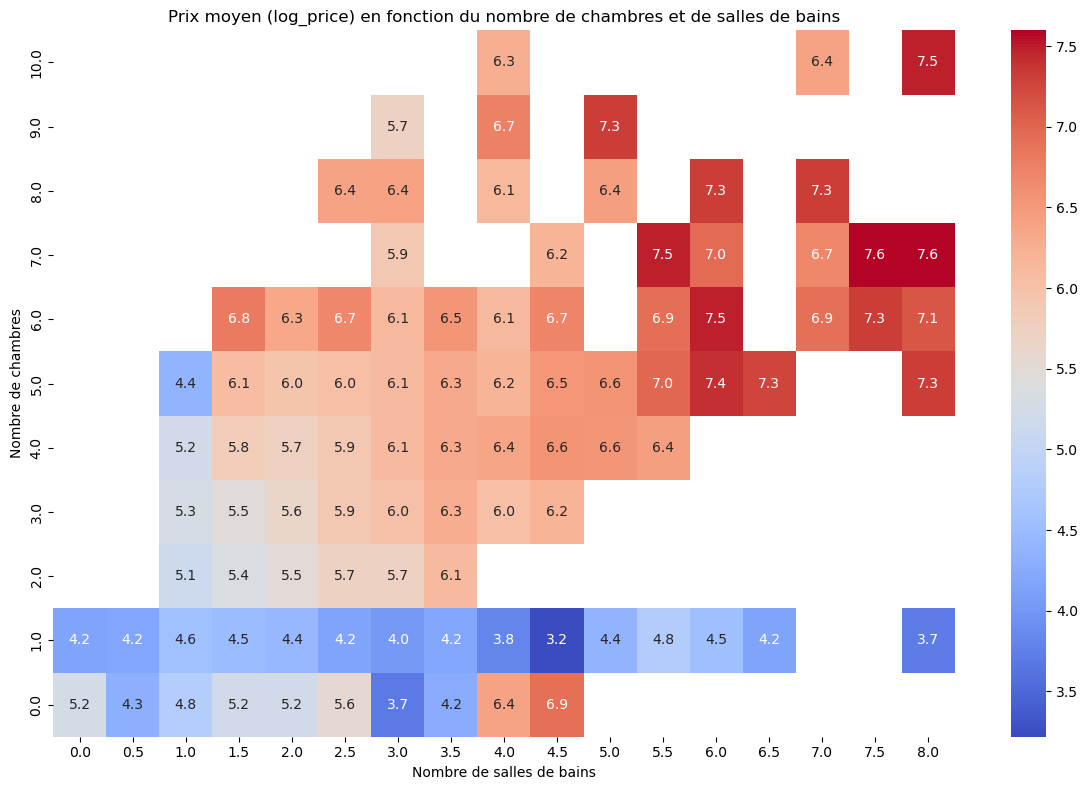

In [59]:
# Cr√©er une table crois√©e pour la moyenne des prix
pivot = Donnee_Train.pivot_table(
    index='bedrooms',
    columns='bathrooms',
    values='log_price',
    aggfunc='mean'
)

# Affichage de la heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Prix moyen (log_price) en fonction du nombre de chambres et de salles de bains')
plt.xlabel('Nombre de salles de bains')
plt.ylabel('Nombre de chambres')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Ici le resulat est sans appel on remarque bien que la temperature de la heatmap augmente lorsque on se d√©place vers le haut en gauche de la map. Le prix augmente donc bien de maniere proportionel lorsque le nombre de salles de bains et/ou de hambres augmente.

### Passons aux variables cat√©gorielles (qualitatives)

Le but maintenant est de regarder la repartition des variables qualtitatives, si elles se repettent et sont  arbitraire commme un avis ou si elles sont choisis parmis des propostions comme le type de logement. Cette partie de l'exploration va nous permettre d'obtenir des informations utiles pour la parties du pr√©processing. 

Nous allons commencer par le `room_type` voir sa r√©partition et son lien avec le prix.

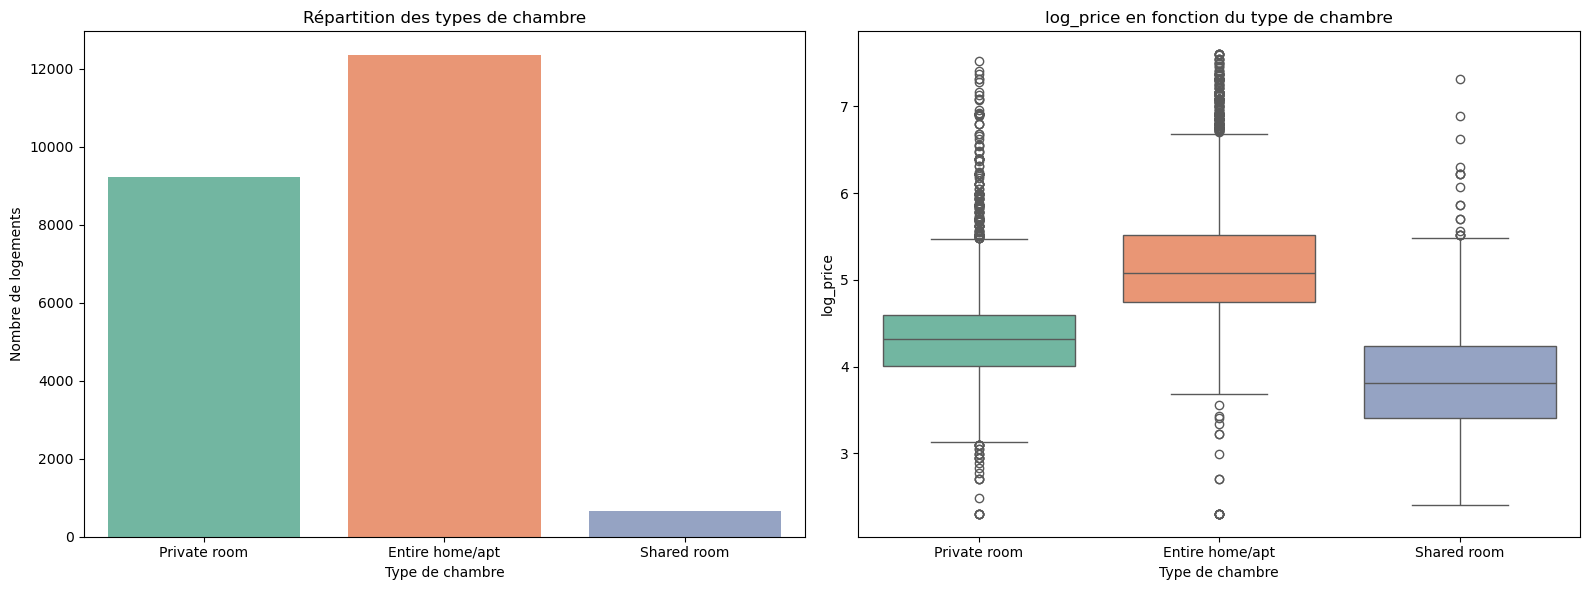

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Countplot du type de chambre 
sns.countplot(
    data=Donnee_Train,
    x='room_type',
    hue='room_type',
    palette='Set2',
    legend=False,
    ax=axes[0]
)
axes[0].set_title("R√©partition des types de chambre")
axes[0].set_xlabel("Type de chambre")
axes[0].set_ylabel("Nombre de logements")

# Boxplot du prix en fonction du type de chambre
sns.boxplot(
    data=Donnee_Train,
    x='room_type',
    hue='room_type',
    legend=False,
    y='log_price',
    palette='Set2',
    ax=axes[1]
)
axes[1].set_title("log_price en fonction du type de chambre")
axes[1].set_xlabel("Type de chambre")
axes[1].set_ylabel("log_price")

plt.tight_layout()
plt.show()

On voit que la majorit√© des logements sont des appartements ou maisons entiers (Entire home/apt). Ensuite viennent les chambres priv√©es, puis les chambres partag√©es qui elles sont tr√®s rares.

Pour le prix, c‚Äôest assez clair : les logements entiers (appartement ou maison) sont les plus cher  ce qui est logique pour une plateforme comme AirBnBe, on retrouve apr√®s les chambres priv√©es. Les chambres partag√©es quant √† elles sont nettement moins ch√®res.
Cette variable a donc clairement un impact sur le prix et sera tr√®s utile pour la pr√©diction.

Nous allons regarder la repartition pour `property_type` ? Pour cela nous allons faire les memes graphiques car c'est le plus simpke et intuitif a comprendre nous allons par contre selectionner les 10 types les plus frequent par soucis de lisibilit√©.

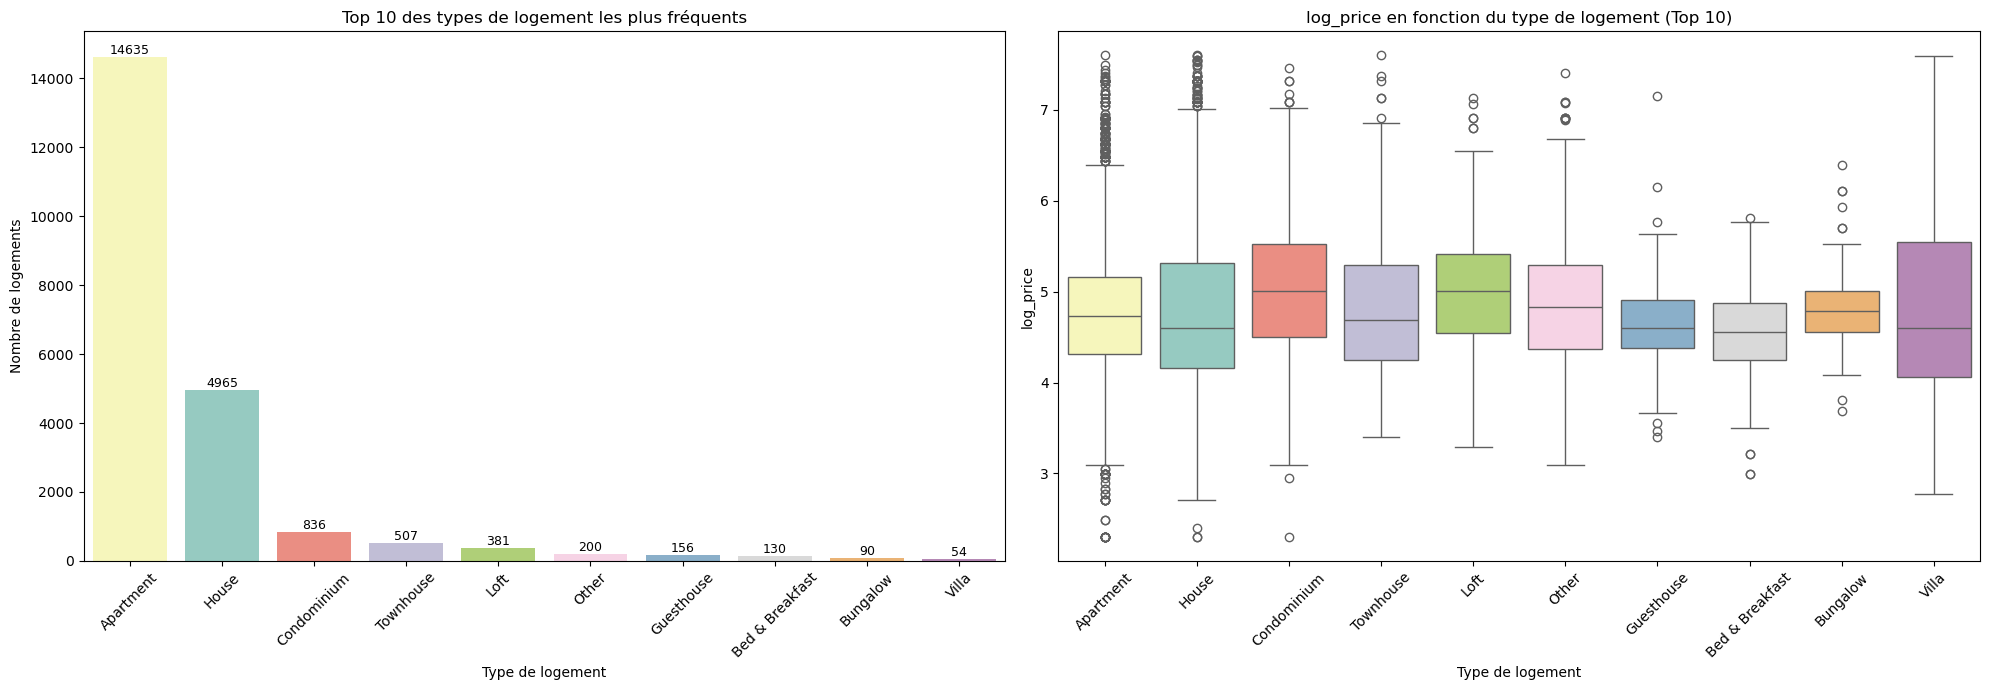

In [98]:
# S√©lection des 10 types de logement les plus fr√©quents
top_property_types = Donnee_Train['property_type'].value_counts().head(10).index
filtered_df = Donnee_Train[Donnee_Train['property_type'].isin(top_property_types)]

# Affichage c√¥te √† c√¥te : countplot + boxplot
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Countplot
sns.countplot(data=filtered_df,x='property_type',hue='property_type',order=top_property_types,palette='Set3',legend=False,ax=axes[0])
axes[0].set_title("Top 10 des types de logement les plus fr√©quents")
axes[0].set_xlabel("Type de logement")
axes[0].set_ylabel("Nombre de logements")
axes[0].tick_params(axis='x', rotation=45)  # Rotation des labels x pour lisibilit√©

for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=9)

# Boxplot
sns.boxplot(data=filtered_df,x='property_type',hue='property_type',y='log_price',order=top_property_types,palette='Set3',legend=False,ax=axes[1])
axes[1].set_title("log_price en fonction du type de logement (Top 10)")
axes[1].set_xlabel("Type de logement")
axes[1].set_ylabel("log_price")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Les deux graphiques sont tous deux r√©v√©lateurs, m√™me si le second est moins pertinent. Il montre la difficult√© d'√©tablir une relation pr√©cise entre le type de logement et son prix, car les prix sont tr√®s √©tal√©s et pr√©sentent de nombreuses valeurs extr√™mes.

Le premier graphique, en revanche, nous montre que le nombre **d'appartement** parmi les locations est extr√™mement cons√©quent, et que **les maisons** ne sont pas n√©gligeables** non plus.  
Cependant, les autres types de logements ne repr√©sentent qu'une infime partie du jeu de donn√©es.

Cela nous donne donc un indice pr√©cieux pour le **pr√©traitement**  (preprocessing) :  
nous pourrons envisager de regrouper les types de logement en cr√©ant une nouvelle colonne avec trois cat√©gories principales :
- Appartements,
- Maisons,
- Autres types regroup√©s ensemble.

Regardons √† present la `Cancelation_policy` sa r√©partition et son impact face au prix des logements. Pour mieux lire les politique nous avons decider de regrouper toutes les politiques rares dans une seule cat√©gorie. Nous afficherons ensuite la r√©partition du prix par rapport √† ces politiques √† l'aide d'un diagramme violon.

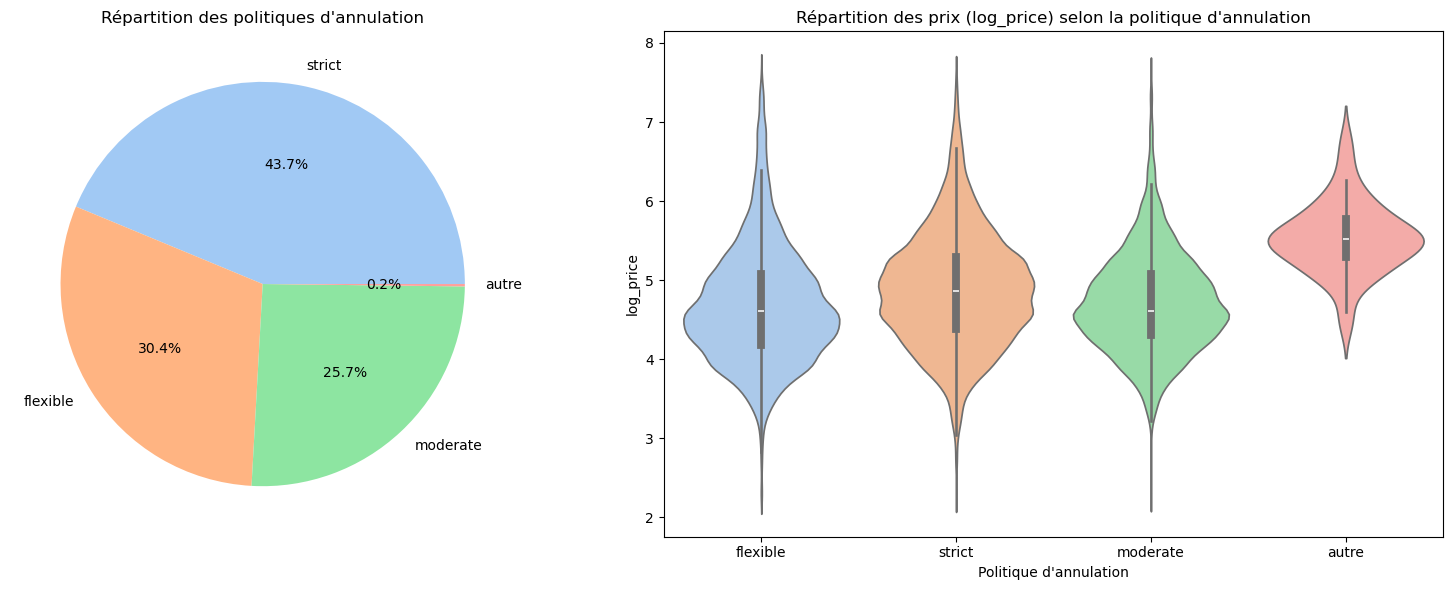

In [112]:
# Simplification de la politique d'annulation
Donnee_Train['cancellation_policy_simplifi√©'] = Donnee_Train['cancellation_policy'].replace({
    'super_strict_30': 'autre',
    'super_strict_60': 'autre'
})
# Ici on a regroup√© les politiques tr√®s rares pour un graphique plus lisible.

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphe 1 : Camembert des politiques d'annulation
Donnee_Train['cancellation_policy_simplifi√©'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    ax=axes[0]
)
axes[0].set_title("R√©partition des politiques d'annulation")
axes[0].set_ylabel("")  # Supprimer le label y pour le pie chart

# Graphe 2 : Violin plot du prix selon la politique
sns.violinplot(data=Donnee_Train,x='cancellation_policy_simplifi√©', hue='cancellation_policy_simplifi√©',y='log_price',palette='pastel', legend=False,ax=axes[1])
axes[1].set_title("R√©partition des prix (log_price) selon la politique d'annulation")
axes[1].set_xlabel("Politique d'annulation")
axes[1].set_ylabel("log_price")

plt.tight_layout()
plt.show()


pour la majorit√© des logement une politique "strict" ou "flexible" est utilis√© , suivie de "moderate" avec un peu moins de bien . Les politiques tr√®s strictes (super_strict_30 et 60) sont ultra rares, donc on les a regroup√©es dans une cat√©gorie "autre".

Quand on regarde les prix, on remarque que les logements avec une politique plus souple (comme "flexible") sont en moyenne un peu moins chers que ceux avec une politique stricte. Mais globalement, les √©carts ne sont pas √©normes et les "violons" se ressemble et s'elargisse de la meme maniere globalement ce qui montre que la repartition se fait globalement de la m√™me mani√®re. 
On conclue que cette variable n'est pas pertinente pour la suite. 

Continuons avec la derniere variable cat√©gorielle : "instant_bookable" qui est la seule variable boolenne du jeu

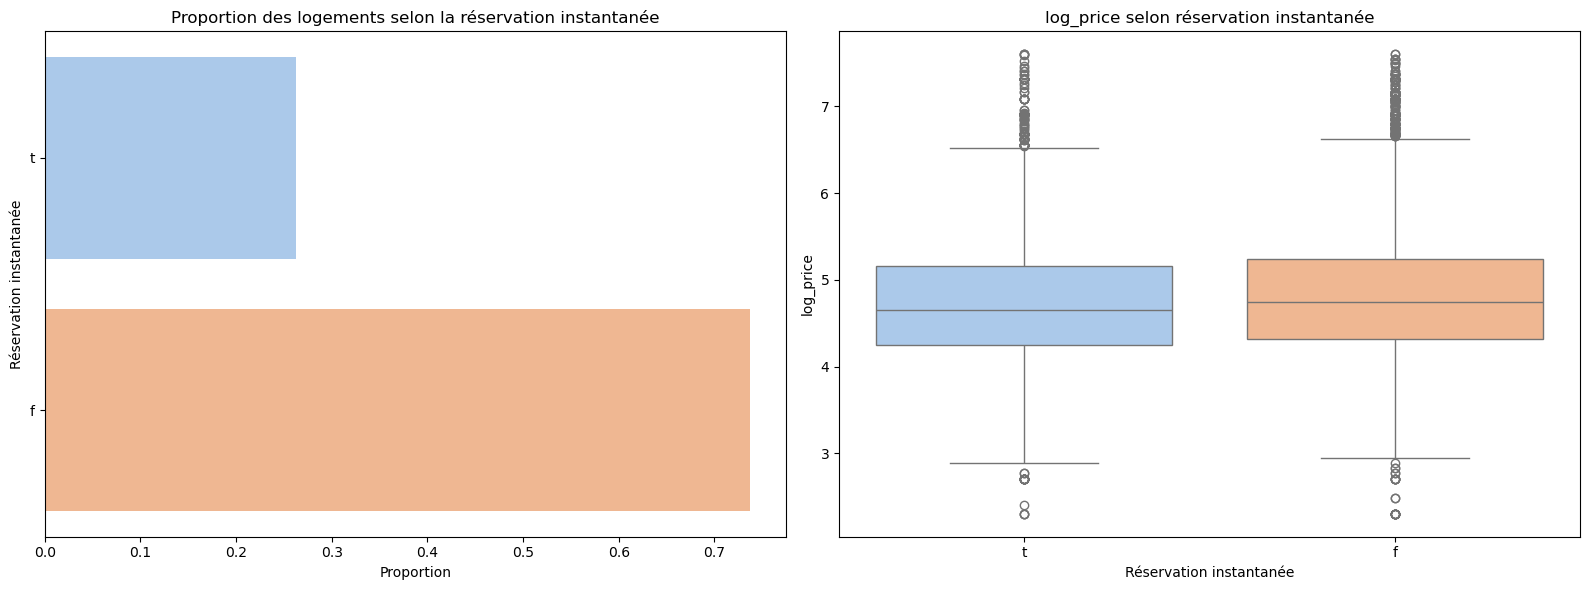

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1er graphique : Proportion r√©servation instantan√©e
instant_counts = Donnee_Train['instant_bookable'].value_counts(normalize=True).sort_values()

sns.barplot(x=instant_counts.values, y=instant_counts.index,hue=instant_counts.values, legend=False, palette='pastel',ax=axes[0])
axes[0].set_title("Proportion des logements selon la r√©servation instantan√©e")
axes[0].set_xlabel("Proportion")
axes[0].set_ylabel("R√©servation instantan√©e")

# 2√®me graphique : Prix selon r√©servation instantan√©e
sns.boxplot(data=Donnee_Train,x='instant_bookable',y='log_price',hue='instant_bookable', legend=False,palette='pastel', ax=axes[1])
axes[1].set_title("log_price selon r√©servation instantan√©e")
axes[1].set_xlabel("R√©servation instantan√©e")
axes[1].set_ylabel("log_price")

plt.tight_layout()
plt.show()


On remarque tout d'abord qu‚Äôil y a beaucoup de logements qui ne peuvent pas √™tre r√©serv√©s instantan√©ment, avec un rapport d‚Äôenviron **1 pour 4**.

Le second graphique est pertinent car il montre que les deux diagrammes en bo√Æte (boxplots) sont relativement similaires.  
Cela indique que la possibilit√© de r√©servation instantan√©e n'a pas d'impact significatif sur le prix des logements.

Nous pouvons donc conclure que `instant_bookable` est une information int√©ressante sur la r√©servation, mais pas vraiment d√©terminante pour pr√©dire le prix.

On va comparer maintenant la densit√© des logements en fonction des positions de chacuns pour cela nous utiliserons les latitudes et longitudes comme pour un rep√®re.

In [135]:
# Afficher les diff√©rentes villes uniques
villes_uniques = Donnee_Train['city'].unique()
print(villes_uniques)

['LA' 'NYC' 'DC' 'SF' 'Chicago' 'Boston']


Avant d'afficher la carte avec la repartition on r√©cup√®re les differentes villes etudier puis sur internet on regarde leur coordonn√©es r√©elles pour pouvoir les placer sur le graphe.

On cr√©er ensuite le diagramme de la densit√© des logements autour des villes.

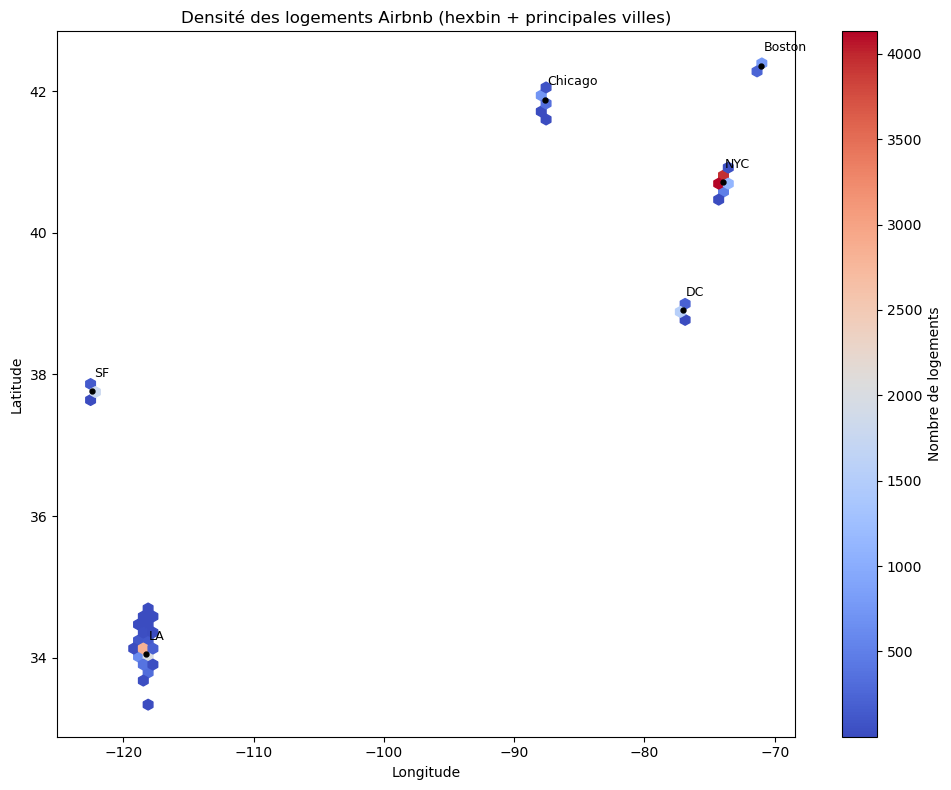

In [155]:
# Dictionnaire des principales villes et de leurs coordonn√©es
villes = {
    'LA': (-118.25, 34.05),
    'NYC': (-74.00, 40.71),
    'DC': (-77.04, 38.91),
    'SF': (-122.42, 37.77),
    'Chicago': (-87.63, 41.88),
    'Boston': (-71.06, 42.36)
}

plt.figure(figsize=(10,8))

# Hexbin plot classique
plt.hexbin(
    Donnee_Train['longitude'],
    Donnee_Train['latitude'],
    gridsize=70,
    cmap='coolwarm',
    mincnt=1
)
plt.colorbar(label='Nombre de logements')
plt.title("Densit√© des logements Airbnb (hexbin + principales villes)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Ajouter les points des villes
for ville, (lon, lat) in villes.items():
    plt.scatter(lon, lat, color='black', marker='.', s=50)  # Points noirs
    plt.text(lon + 0.2, lat + 0.2, ville, fontsize=9, color='black')  # Noms des villes

plt.tight_layout()
plt.show()


On remarque que il y a trois petites villes ( SF, DC, Boston) et trois plus grosses (Chicago, NYC, LA), Des villes ettendu comme LA et NYC presente un √©picentre avec une tres forte densit√©e en logement. On remarque aussi que les villes on  une tendance a s'ettaller sur l'axe Nord-Sud mais moins en fonction de la Longitude.

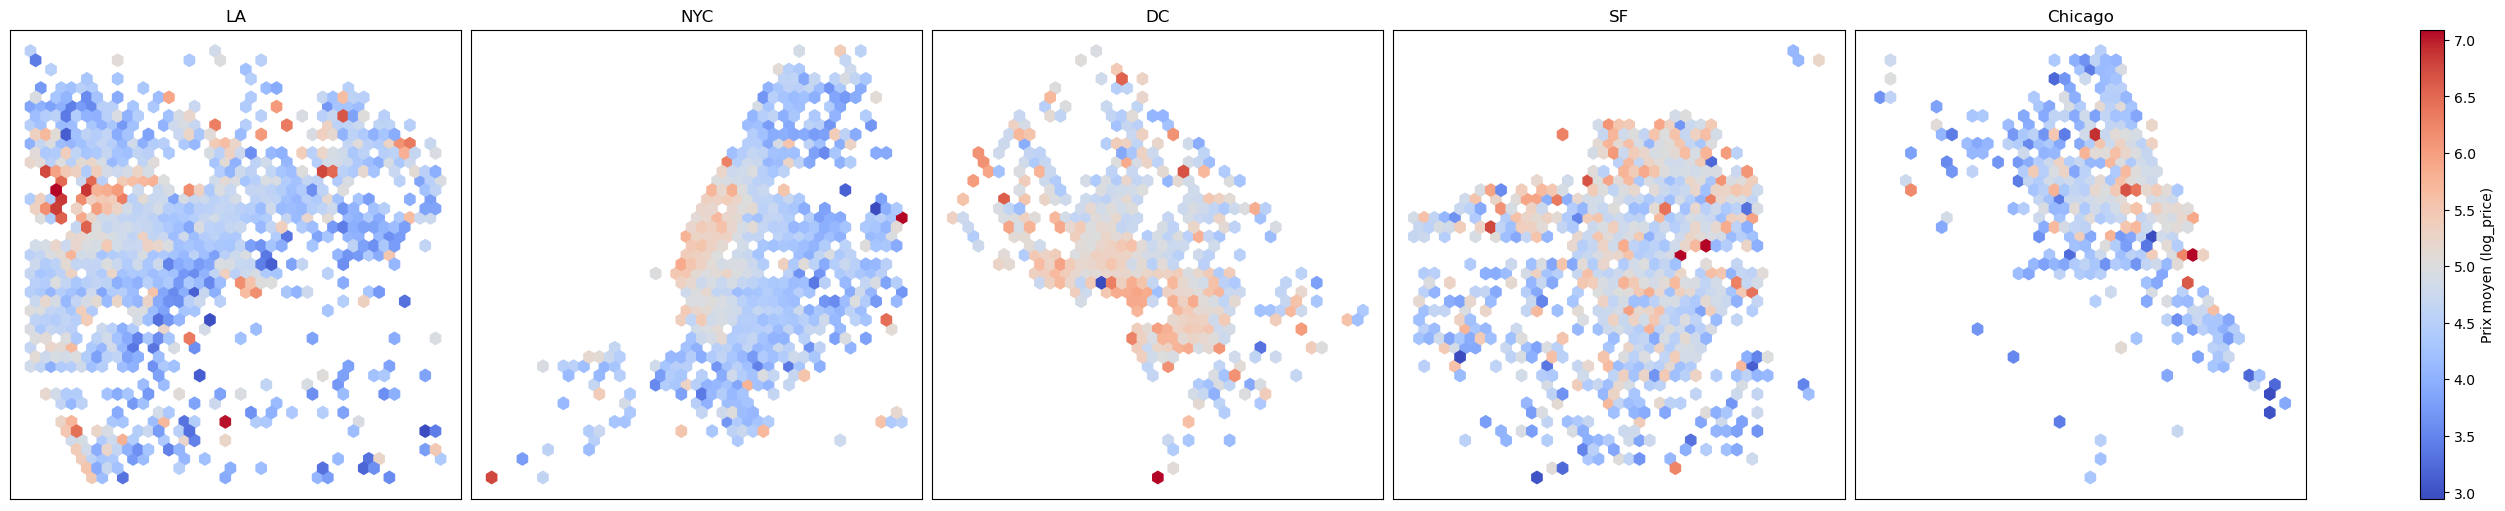

In [160]:
# Dictionnaire des principales villes avec leur centre (lon, lat) pour le zoom
villes = {
    'LA': (-118.25, 34.05),
    'NYC': (-74.00, 40.71),
    'DC': (-77.04, 38.91),
    'SF': (-122.42, 37.77),
    'Chicago': (-87.63, 41.88)
}

# Taille du zoom autour de chaque ville
zoom_lon = 0.2
zoom_lat = 0.2

# Cr√©er une figure avec constrained layout pour √©viter le warning
fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)

# Boucle sur les villes
for ax, (ville, (lon, lat)) in zip(axes, villes.items()):
    # Sous-√©chantillonnage local autour de la ville
    local_df = Donnee_Train[
        (Donnee_Train['longitude'] > lon - zoom_lon) & (Donnee_Train['longitude'] < lon + zoom_lon) &
        (Donnee_Train['latitude'] > lat - zoom_lat) & (Donnee_Train['latitude'] < lat + zoom_lat)
    ]
    
    # Hexbin sur la zone locale
    hb = ax.hexbin(
        local_df['longitude'],
        local_df['latitude'],
        C=local_df['log_price'],
        gridsize=40,
        cmap='coolwarm',
        reduce_C_function=np.mean,
        mincnt=1
    )
    ax.set_title(ville)
    
    # Masquer les ticks des axes
    ax.set_xticks([])
    ax.set_yticks([])

# Ajouter la colorbar pour l'ensemble
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical', label='Prix moyen (log_price)')

plt.show()


Nous avons repr√©sent√© la densit√© des logements et la r√©partition des prix (`log_price`) pour cinq grandes villes : **Los Angeles**, **New York**, **Washington DC**, **San Francisco** et **Chicago**.

Chaque graphique montre la densit√© des logements avec une couleur indiquant le **prix moyen** local :  
- **Rouge** : zones de logements plus chers,  
- **Bleu** : zones de logements moins chers.

On remarque plusieurs √©l√©ments int√©ressants :
- **√Ä New York** et **San Francisco**, on observe des **zones tr√®s concentr√©es de logements chers**, surtout autour du centre-ville.
- **√Ä Los Angeles**, la r√©partition est plus √©tal√©e, avec plusieurs "poches" de prix √©lev√©s dans diff√©rents quartiers.
- **√Ä Washington DC** et **Chicago**, les prix sont globalement plus homog√®nes, avec quelques zones sp√©cifiques plus haut de gamme.

Cette visualisation nous permet de comprendre que la **localisation g√©ographique pr√©cise** a un **impact majeur sur le prix** d‚Äôun logement Airbnb.  
C‚Äôest donc une dimension importante √† int√©grer dans les futurs mod√®les de pr√©diction.

# Pretraitement des donn√©es 

Apr√®s avoir explor√© et visualis√© les variables les plus importantes, on a maintenant une bonne id√©e de celles qui influencent le prix (log_price) et de la mani√®re dont elles se comportent. On va donc passer √† la modification et transformation des variables pour pr√©parer les donn√©es √† l'entra√Ænement de nos mod√®les.

Cette √©tape inclut le nettoyage, le traitement des valeurs manquantes, l‚Äôencodage des variables cat√©gorielles et la cr√©ation de nouvelles variables utiles. C‚Äôest une phase essentielle pour am√©liorer la performance des algorithmes.

In [178]:
# On travaille sur une copie pour pas casser l'original
Donnees = Donnee_Train.copy()

# Remplissage des colonnes num√©riques (par la m√©diane)
Donnees['bathrooms'] = Donnees['bathrooms'].fillna(Donnees['bathrooms'].median())
Donnees['bedrooms'] = Donnees['bedrooms'].fillna(Donnees['bedrooms'].median())
Donnees['beds'] = Donnees['beds'].fillna(Donnees['beds'].median())

# Note moyenne des avis ‚Üí remplie avec la moyenne
Donnees['review_scores_rating'] = Donnees['review_scores_rating'].fillna(Donnees['review_scores_rating'].mean())

# Taux de r√©ponse de l‚Äôh√¥te ‚Üí on enl√®ve le %, convertit en float, puis on met 0 si manquant
Donnees['host_response_rate'] = Donnees['host_response_rate'].str.rstrip('%').astype(float)
Donnees['host_response_rate'] = Donnees['host_response_rate'].fillna(0)

# Variables bool√©ennes ‚Üí t/f deviennent 1/0
Donnees['host_has_profile_pic'] = Donnees['host_has_profile_pic'].map({'t': 1, 'f': 0}).fillna(0)
Donnees['host_identity_verified'] = Donnees['host_identity_verified'].map({'t': 1, 'f': 0}).fillna(0)

# Anciennet√© de l‚Äôh√¥te (on garde juste l‚Äôann√©e)
Donnees['host_since'] = pd.to_datetime(Donnees['host_since'], errors='coerce')
Donnees['anciennete_host'] = Donnees['host_since'].apply(lambda d: 2025 - d.year if pd.notnull(d) else 0)
Donnees.drop(columns=['host_since'], inplace=True)

# Conversion des dates des reviews en nombre de jours depuis 01/01/2025
Donnees['first_review'] = pd.to_datetime(Donnees['first_review'], errors='coerce')
Donnees['last_review'] = pd.to_datetime(Donnees['last_review'], errors='coerce')
Donnees['jours_depuis_dernier_review'] = (pd.to_datetime("2025-01-01") - Donnees['last_review']).dt.days
Donnees['jours_depuis_premier_review'] = (pd.to_datetime("2025-01-01") - Donnees['first_review']).dt.days
Donnees['jours_depuis_dernier_review'] = Donnees['jours_depuis_dernier_review'].fillna(-1)
Donnees['jours_depuis_premier_review'] = Donnees['jours_depuis_premier_review'].fillna(-1)

# Pour le quartier et le code postal ‚Üí on prend la valeur la plus fr√©quente
Donnees['neighbourhood'] = Donnees['neighbourhood'].fillna(Donnees['neighbourhood'].mode()[0])
Donnees['zipcode'] = Donnees['zipcode'].fillna(Donnees['zipcode'].mode()[0])


Suite √† l‚Äôexploration r√©alis√©e pr√©c√©demment, on a identifi√© plusieurs colonnes avec des valeurs manquantes ou des formats peu adapt√©s pour l‚Äôapprentissage automatique. Dans cette partie, on applique un nettoyage coh√©rent avec ce qu‚Äôon a observ√©.

Pour les variables num√©riques comme le nombre de chambres, de lits ou de salles de bain, on a choisi d‚Äôutiliser la m√©diane, car elle est moins sensible aux valeurs extr√™mes. La note moyenne des avis a √©t√© compl√©t√©e avec la moyenne, ce qui est logique √©tant donn√© sa distribution continue et r√©guli√®re.

Le taux de r√©ponse de l‚Äôh√¥te, qui √©tait exprim√© en pourcentage, a √©t√© transform√© en valeur num√©rique puis compl√©t√© par 0 lorsque l‚Äôinformation √©tait absente, en consid√©rant qu‚Äôun h√¥te sans donn√©es ne r√©pond probablement pas. Pour les colonnes indiquant la pr√©sence d‚Äôune photo de profil ou une v√©rification d‚Äôidentit√©, on a converti les valeurs textuelles en bool√©ens, et les valeurs manquantes ont √©t√© consid√©r√©es comme ¬´ non ¬ª.

On a √©galement transform√© la date d‚Äôinscription de l‚Äôh√¥te en une variable repr√©sentant son anciennet√© en ann√©es, ce qui est plus simple et plus utile dans un mod√®le. De la m√™me fa√ßon, les dates du premier et du dernier avis ont √©t√© converties en nombre de jours √©coul√©s depuis une date de r√©f√©rence (01/01/2025), afin de garder une information temporelle pertinente.

Enfin, pour les colonnes textuelles comme le quartier ou le code postal, on a compl√©t√© les valeurs manquantes avec la modalit√© la plus fr√©quente, ce qui permet de conserver l‚Äôinformation sans introduire de biais important.

# Transformation de variable

commencons par la variable "amenities"

In [183]:
def extract_amenities(amenity_string):
    try:
        amenity_string = amenity_string.strip('{}')
        items = [a.strip().strip('"') for a in amenity_string.split(',')]
        return items
    except:
        return []

Donnees['parsed_amenities'] = Donnees['amenities'].apply(extract_amenities)

# On rassemble tous les √©quipements et on compte combien de fois ils apparaissent
all_amenities = Donnees['parsed_amenities'].explode()
amenity_counts = all_amenities.value_counts()

#les 20 √©quipements les plus fr√©quents pour nos predictions 
top_amenities = amenity_counts.head(20)


In [185]:
# Cr√©ation d'une colonne 0/1 pour chaque √©quipement du top 20
for equipement in top_amenities.index:
    col_name = f'amenity_{equipement}'
    Donnees[col_name] = Donnees['parsed_amenities'].apply(lambda x: int(equipement in x))

# (optionnel) Aper√ßu du r√©sultat avec les nouvelles colonnes cr√©√©es
Donnees[[f'amenity_{e}' for e in top_amenities.index]].head()


amenity_Wireless Internet  amenity_Kitchen  amenity_Heating  \
0                          1                1                0   
1                          1                1                1   
2                          1                1                1   
3                          1                1                1   
4                          1                1                1   

   amenity_Essentials  amenity_Smoke detector  amenity_Air conditioning  \
0                   1                       1                         0   
1                   1                       1                         1   
2                   1                       1                         1   
3                   1                       1                         1   
4                   1                       1                         0   

   amenity_TV  amenity_Shampoo  amenity_Hangers  \
0           1                1                1   
1           0                0                0   
2           1                1                0   
3           1                1                1   
4           1                1                1   

   amenity_Carbon monoxide detector  amenity_Internet  \
0                                 0                 0   
1                                 1                 0   
2                                 1                 0   
3                                 1                 1   
4                                 1                 1   

   amenity_Laptop friendly workspace  amenity_Washer  amenity_Hair dryer  \
0                                  0               1                   1   
1                                  0               0                   1   
2                                  1               1                   0   
3                                  1               0                   1   
4                                  1               1                   1   

   amenity_Dryer  amenity_Iron  amenity_Family/kid friendly  \
0              1             1                            0   
1              0             1                            1   
2              1             0                            1   
3              0             1                            1   
4              1             1                            1   

   amenity_Fire extinguisher  amenity_First aid kit  \
0                          0                      0   
1                          1                      0   
2                          1                      1   
3                          0                      0   
4                          0                      1   

   amenity_translation missing: en.hosting_amenity_50  
0                                                  0   
1                                                  1   
2                                                  0   
3                                                  1   
4                                                  0

La colonne amenities, c‚Äôest juste une grosse cha√Æne de texte avec tous les √©quipements dispo dans un logement. Sauf que pour un mod√®le de machine learning, √ßa ne sert √† rien dans ce format. Du coup, on a commenc√© par transformer cette cha√Æne en vraie liste, histoire de pouvoir bosser dessus proprement.

Ensuite, on a regard√© quels √©quipements revenaient le plus souvent dans les logements. On en a gard√© les 20 les plus fr√©quents, car ce sont s√ªrement ceux qui ont le plus d‚Äôimpact sur le prix (genre Wi-Fi, cuisine, clim‚Ä¶).

Pour finir, on a cr√©√© une nouvelle colonne pour chaque √©quipement, o√π on met 1 si le logement l‚Äôa, et 0 sinon. Comme √ßa, on garde un max d‚Äôinfo utile, mais sous une forme claire et exploitable par nos mod√®les.



Passons a "longitude" et "latitude" : 

In [189]:
from sklearn.cluster import KMeans

# On r√©cup√®re les colonnes latitude et longitude
coordonnees = Donnees[['latitude', 'longitude']]

# On applique un clustering simple pour diviser les logements en 5 zones
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
Donnees['zone_geo'] = kmeans.fit_predict(coordonnees)

# R√©sultat : chaque logement est assign√© √† une "zone g√©ographique"
Donnees[['latitude', 'longitude', 'zone_geo']].head()


latitude   longitude  zone_geo
0  33.782712 -118.134410         3
1  40.705468  -73.909439         1
2  38.917537  -77.031651         4
3  40.736001  -73.924248         1
4  37.744896 -122.430665         0

En cherchant un peu ce qu'il etait possible de faire avec une longitude et une latitude on a trouv√© la possibilit√© de faire des agreagation en zone geographique , pour pouvoir garder ces variables qui semble quand meme assez importante d'un point de vue g√©n√©ral, on a vu dans la heatmap dans la partie exploration que la latitude et la longitude ont une grosse corr√©lation donc on aurait pu en garder qu'une des deux, mais en ayant trouver cette methode nous avons fait le choix de reunir les 2 dans cette nouvelle variable "zone_geo" 

Le nombre de chambres, de lits ou de salles de bain est utile, mais ce qui compte vraiment pour un voyageur, c‚Äôest l‚Äôespace ou le confort disponible par personne. Par exemple, un logement avec 3 lits pour 2 personnes n‚Äôa pas le m√™me standing qu‚Äôun autre avec 3 lits pour 6 personnes.

Pour mieux repr√©senter cette id√©e, on va donc cr√©er quelques ratios simples : nombre de chambres par personne, nombre de lits par personne, et nombre de salles de bain par personne. Ces nouvelles variables peuvent aider les mod√®les √† mieux comprendre le niveau de confort offert par chaque logement.



In [193]:
# on s'assure qu'on ne divise jamais par z√©ro ( au debut on avait pas mis cette ligne et ca marchait pas bien ) 
Donnees['accommodates'] = Donnees['accommodates'].replace(0, 1)

# au cas ou les variables soient incompl√®tes
Donnees['bathrooms'] = Donnees['bathrooms'].fillna(Donnees['bathrooms'].median())
Donnees['bedrooms'] = Donnees['bedrooms'].fillna(Donnees['bedrooms'].median())
Donnees['beds'] = Donnees['beds'].fillna(Donnees['beds'].median())

# Cr√©ation des ratios comme dans le TD1
Donnees['ratio_chambres_pers'] = Donnees['bedrooms'] / Donnees['accommodates']
Donnees['ratio_lits_pers'] = Donnees['beds'] / Donnees['accommodates']
Donnees['ratio_sdb_pers'] = Donnees['bathrooms'] / Donnees['accommodates']

Donnees[['ratio_chambres_pers', 'ratio_lits_pers', 'ratio_sdb_pers']].head()


ratio_chambres_pers  ratio_lits_pers  ratio_sdb_pers
0             0.000000         0.666667        0.333333
1             0.250000         0.500000        0.500000
2             0.333333         0.333333        0.333333
3             1.000000         1.000000        1.000000
4             0.500000         0.500000        0.250000

Regardons desormais la variable " description " : 

La description d‚Äôun logement peut contenir des infos tr√®s utiles sur le style ou la qualit√© de l‚Äôappartement, mais comme c‚Äôest du texte brut, ce n‚Äôest pas exploitable directement. Plut√¥t que de tout analyser en d√©tail (ce qui serait long), on a d√©cid√© de rep√©rer simplement certains mots-cl√©s fr√©quents comme ‚Äúluxury‚Äù, ‚Äúcozy‚Äù ou ‚Äúcentral‚Äù.

Pour la selection des mots on a regarder a la main quelques mots, mais cette liste est evolutive...

On a donc cr√©√© une colonne binaire pour chaque mot-cl√©, avec 1 si le mot est pr√©sent dans la description, et 0 sinon. √áa permet de capturer des √©l√©ments subjectifs ou marketing qui peuvent influencer le prix, sans passer par des m√©thodes de traitement de texte avanc√©es.

In [197]:
# On remplace les valeurs manquantes par une cha√Æne vide pour √©viter les erreurs 
# au debut on avait des erreurs donc on a mis des chaines vide, on a aussi essayer avec 
# un mot "commum" a tous les logements mais c'etait non concluant. 
Donnees['description'] = Donnees['description'].fillna("")

mots_cles = ['luxury', 'cozy', 'modern', 'spacious', 'central', 'downtown', 'quiet', 'comfortable']

for mot in mots_cles:
    Donnees[f'desc_has_{mot}'] = Donnees['description'].str.lower().str.contains(mot).astype(int)


#Donnees[[f'desc_has_{mot}' for mot in mots_cles]].head()


Et pour le code postal ?  

Le code postal donne une indication sur la localisation du logement, mais comme il y a beaucoup de valeurs diff√©rentes, l‚Äôencoder directement n‚Äôapporte pas grand-chose. Pour en tirer une info utile, on a calcul√© le prix moyen observ√© pour chaque code postal, puis on a cr√©√© une nouvelle colonne (prix_moyen_zip) qui associe ce prix moyen √† chaque logement.

On pourrait penser que √ßa fait doublon avec la variable zone_geo qu‚Äôon a cr√©√©e plus t√¥t avec KMeans, mais en r√©alit√© les deux se compl√®tent bien. zone_geo classe les logements par proximit√© g√©ographique, sans conna√Ætre les prix. prix_moyen_zip, lui, se base uniquement sur les prix r√©ellement observ√©s dans les donn√©es. L‚Äôun donne une info spatiale, l‚Äôautre une info √©conomique.

En combinant les deux, on donne au mod√®le √† la fois l‚Äôemplacement g√©n√©ral du logement et le niveau de prix moyen autour, ce qui est tr√®s pertinent pour la pr√©diction.

In [201]:
#toujours pareil si on rempli pas les na alors ca marche pas bien 
Donnees['zipcode'] = Donnees['zipcode'].fillna(Donnees['zipcode'].mode()[0])

# On calcule le prix moyen !! attention !!  on le fait par code postal
prix_moyen_par_zip = Donnees.groupby('zipcode')['log_price'].mean()


Donnees['prix_moyen_zip'] = Donnees['zipcode'].map(prix_moyen_par_zip)


#Donnees[['zipcode', 'prix_moyen_zip']].head()


Et on va terminer par le quartier ! 

Comme pour le code postal juste avant , le quartier (neighbourhood) peut donner une indication sur la localisation du logement. Mais l√† encore, il y a trop de cat√©gories diff√©rentes, et certaines n‚Äôapparaissent que quelques fois.

Au lieu de les encoder toutes, on a d√©cid√© de se concentrer sur les quartiers les plus repr√©sent√©s dans le dataset. On a donc cr√©√© une nouvelle colonne quartier_top qui vaut 1 si le logement se trouve dans l‚Äôun des 15 quartiers les plus fr√©quents, et 0 sinon. Cela permet de garder une information sur les zones "actives", sans trop complexifier les donn√©es.  

on avait essayer une autre methode pour garder plus d'information sur le quartier mais c'etait trop de complexe pour nous a gerer dans l'encodage par la suite ! 

In [205]:
# idem que au dessus pour eviter les erreurs
Donnees['neighbourhood'] = Donnees['neighbourhood'].fillna(Donnees['neighbourhood'].mode()[0])

# On r√©cup√®re les 15 quartiers les plus pr√©sents
top_neighbourhoods = Donnees['neighbourhood'].value_counts().head(15)

#et la methode en elle meme pour recup des 0 et des 1 
Donnees['quartier_top'] = Donnees['neighbourhood'].apply(lambda x: 1 if x in top_neighbourhoods.index else 0)



# Suppression des donn√©es inutiles 

In [208]:
colonnes_a_supprimer = [
    'amenities', 'description', 'zipcode', 'neighbourhood',
    'name', 'first_review', 'last_review']


Donnees.drop(columns=colonnes_a_supprimer, inplace=True)



Apr√®s toutes nos transformations, certaines colonnes ne sont plus utiles dans leur format d‚Äôorigine. Par exemple, on a extrait des √©quipements √† partir de amenities, rep√©r√© des mots-cl√©s dans description, et transform√© zipcode ou neighbourhood en variables num√©riques ou binaires.

Du coup, on peut maintenant supprimer ces colonnes pour ne garder que les variables vraiment exploitables pour l'entra√Ænement du mod√®le.

# Encodage 

Maintenant que toutes nos variables ont √©t√© nettoy√©es et enrichies gr√¢ce au feature engineering, on termine par un encodage final des derni√®res variables cat√©gorielles restantes. On utilise un One-Hot Encoding pour les convertir en colonnes binaires exploitables par les mod√®les. On s‚Äôassure ainsi que notre jeu de donn√©es est enti√®rement num√©rique et pr√™t pour l‚Äôentra√Ænement.

Pour que les mod√®les de machine learning puissent traiter les variables cat√©gorielles restantes (comme certains types de zones ou labels), on utilise la fonction get_dummies() de la biblioth√®que Pandas. Cette fonction permet de transformer une colonne contenant des cat√©gories textuelles en plusieurs colonnes binaires (0 ou 1), ce qu'on appelle aussi un encodage One-Hot.

Par exemple, si une colonne contient trois valeurs : A, B et C, get_dummies() va cr√©er deux colonnes : is_B et is_C. Si une ligne vaut A, alors les deux colonnes auront la valeur 0. On ne garde que n-1 colonnes gr√¢ce au param√®tre drop_first=True pour √©viter la redondance (multicolin√©arit√©) dans certains mod√®les comme la r√©gression lin√©aire.

On a choisi cette m√©thode car elle est simple, int√©gr√©e dans Pandas, et surtout recommand√©e dans la documentation officielle (pandas.pydata.org) pour l'encodage des variables cat√©gorielles quand on utilise des algorithmes qui ne g√®rent pas directement les textes ou les labels.

In [214]:
# Suppression des colonnes probl√©matiques (texte, inutiles ou d√©j√† trait√©es)
colonnes_a_supprimer_si_existent = ['parsed_amenities', 'amenities', 'host_since', 'description']
for col in colonnes_a_supprimer_si_existent:
    if col in Donnees.columns:
        Donnees.drop(columns=col, inplace=True)

# On identifie les colonnes cat√©gorielles
colonnes_object = Donnees.select_dtypes(include='object').columns.tolist()

# On garde uniquement celles avec un nombre de modalit√©s raisonnable (ex: < 200)
colonnes_object_filtrees = [
    col for col in colonnes_object if Donnees[col].nunique() < 200
]

# Encodage final des colonnes cat√©gorielles filtr√©es
Donnees_encoded = pd.get_dummies(Donnees, columns=colonnes_object_filtrees, drop_first=True)

# V√©rification
Donnees_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 100 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   id                                                  22234 non-null  int64  
 1   log_price                                           22234 non-null  float64
 2   accommodates                                        22234 non-null  int64  
 3   bathrooms                                           22234 non-null  float64
 4   cleaning_fee                                        22234 non-null  bool   
 5   host_has_profile_pic                                22234 non-null  float64
 6   host_identity_verified                              22234 non-null  float64
 7   host_response_rate                                  22234 non-null  float64
 8   latitude                                            22234 non-null  float64

# modelisation

Avant de tester des mod√®les plus complexes, on commence par une r√©gression lin√©aire simple pour poser une premi√®re baseline. Ce mod√®le est rapide √† entra√Æner et permet de voir si nos variables ont d√©j√† un pouvoir pr√©dictif.

On s√©pare d‚Äôabord les donn√©es en deux parties : 80‚ÄØ% pour l‚Äôentra√Ænement, et 20‚ÄØ% pour le test. On √©value ensuite la performance avec la RMSE (Root Mean Squared Error), qui donne une id√©e de l‚Äô√©cart moyen entre les pr√©dictions du mod√®le et les vraies valeurs.

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# S√©paration des variables explicatives et de la cible
X = Donnees_encoded.drop(columns=['log_price'])
y = Donnees_encoded['log_price']

# Division des donn√©es en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cr√©ation et entra√Ænement du mod√®le
model = LinearRegression()
model.fit(X_train, y_train)

# Pr√©dictions
y_pred = model.predict(X_test)

# √âvaluation du mod√®le avec la RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE (R√©gression lin√©aire) : {rmse:.4f}")


RMSE (R√©gression lin√©aire) : 0.4060


In [220]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# On suppose que Donnees_encoded existe d√©j√† dans le notebook
X = Donnees_encoded.drop(columns=['log_price'])
y = Donnees_encoded['log_price']

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mod√®les √† tester
modeles = {
    "R√©gression lin√©aire": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Arbre de d√©cision": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Liste pour stocker les r√©sultats
resultats = []

# Entra√Ænement + pr√©diction + √©valuation pour chaque mod√®le
for nom, modele in modeles.items():
    modele.fit(X_train, y_train)
    y_pred = modele.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultats.append({
        'Mod√®le': nom,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R¬≤': round(r2, 4)
    })

# Affichage des r√©sultats
df_resultats = pd.DataFrame(resultats).sort_values(by='RMSE')
print(df_resultats)


C:\Users\ebeni\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.01416e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


                Mod√®le    RMSE     MAE      R¬≤
5    Gradient Boosting  0.3958  0.2865  0.6942
4        Random Forest  0.3993  0.2865  0.6887
0  R√©gression lin√©aire  0.4060  0.2930  0.6782
1                Ridge  0.4060  0.2930  0.6783
3    Arbre de d√©cision  0.5872  0.4218  0.3270
2                Lasso  0.7106  0.5577  0.0144


# Rajout de variable

nous avons d√©cid√© de rajouter des variables car les resultats n'etait pas assez concluant selon nous 

In [102]:
# Recharger uniquement la colonne 'amenities' depuis le CSV d'origine
original_df = pd.read_csv("airbnb_train.csv", usecols=['id', 'amenities'])

# Fusionner avec le DataFrame actuel (Donnees) via la colonne 'id'
Donnees = Donnees.merge(original_df, on='id', how='left')

# Reparser les √©quipements en liste
def extract_amenities(amenity_string):
    try:
        amenity_string = amenity_string.strip('{}')
        items = [a.strip().strip('"') for a in amenity_string.split(',')]
        return items
    except:
        return []

Donnees['parsed_amenities'] = Donnees['amenities'].apply(extract_amenities)

# Cr√©er la nouvelle feature : nombre total d‚Äô√©quipements
Donnees['nb_equipements_total'] = Donnees['parsed_amenities'].apply(len)

# Aper√ßu
Donnees[['id', 'nb_equipements_total', 'parsed_amenities']].head()

id  nb_equipements_total  \
0   5708593                    15   
1  14483613                    25   
2  10412649                    20   
3  17954362                    30   
4   9969781                    24   

                                    parsed_amenities  
0  [TV, Wireless Internet, Kitchen, Free parking ...  
1  [Wireless Internet, Air conditioning, Kitchen,...  
2  [TV, Wireless Internet, Air conditioning, Kitc...  
3  [TV, Cable TV, Internet, Wireless Internet, Ai...  
4  [TV, Cable TV, Internet, Wireless Internet, Ki...

La colonne amenities contient une liste d‚Äô√©quipements pour chaque logement, mais sous forme de texte brut, donc pas exploitable directement.
On a d‚Äôabord recharg√© cette colonne depuis le fichier CSV d‚Äôorigine, puis on l‚Äôa transform√©e en vraie liste Python √† l‚Äôaide d‚Äôune petite fonction.

Ensuite, on a cr√©√© une nouvelle variable nb_equipements_total qui compte le nombre total d‚Äô√©quipements diff√©rents pour chaque logement.
Cela nous permet d‚Äôavoir une indication du niveau d‚Äô√©quipement global de chaque annonce, ce qui peut clairement influencer le prix. 



In [140]:
# Calcul du prix moyen par zone d√©j√† existante
prix_moyen_par_zone = Donnees.groupby('zone_geo')['log_price'].mean()
Donnees['prix_moyen_zone_geo'] = Donnees['zone_geo'].map(prix_moyen_par_zone)

Puisqu'on a d√©j√† regroup√© les logements en zones g√©ographiques (zone_geo), on va maintenant calculer le prix moyen dans chaque zone .

On ajoute cette information dans une nouvelle variable "prix_moyen_zone_geo". Cela aide notre mod√®le √† comprendre les diff√©rences de niveau de prix entre les zones, sans avoir besoin de conna√Ætre pr√©cis√©ment les quartiers.

In [107]:
# Si la colonne 'amenities' n'existe plus, on la recharge depuis le fichier original
if 'amenities' not in Donnees.columns:
    original_df = pd.read_csv("airbnb_train.csv", usecols=['id', 'amenities'])
    Donnees = Donnees.merge(original_df, on='id', how='left')

# On transforme la cha√Æne de caract√®res en vraie liste d'√©quipements
def extract_amenities(amenity_string):
    try:
        amenity_string = amenity_string.strip('{}')
        items = [a.strip().strip('"') for a in amenity_string.split(',')]
        return items
    except:
        return []

Donnees['parsed_amenities'] = Donnees['amenities'].apply(extract_amenities)

# On calcule le nombre total d'√©quipements list√©s pour chaque logement
Donnees['nb_equipements_total'] = Donnees['parsed_amenities'].apply(len)

# On √©vite la division par z√©ro en rempla√ßant 0 par 1
Donnees['accommodates'] = Donnees['accommodates'].replace(0, 1)

# On calcule le ratio √©quipements / personnes
Donnees['equipement_par_pers'] = Donnees['nb_equipements_total'] / Donnees['accommodates']

# Aper√ßu
Donnees[['nb_equipements_total', 'accommodates', 'equipement_par_pers']].head()

nb_equipements_total  accommodates  equipement_par_pers
0                    15             3             5.000000
1                    25             4             6.250000
2                    20             6             3.333333
3                    30             1            30.000000
4                    24             4             6.000000

Apr√®s avoir extrait la liste compl√®te des √©quipements pour chaque logement (√† partir de la colonne amenities), on a compt√© le nombre total d‚Äô√©quipements dans une nouvelle variable : nb_equipements_total.

Mais on s‚Äôest dit que le nombre seul n'√©tait pas suffisant. Un logement avec 10 √©quipements pour 10 personnes n‚Äôa pas le m√™me confort qu‚Äôun logement avec 10 √©quipements pour 2 personnes.

Du coup, on a cr√©√© une nouvelle variable plus pertinente : equipement_par_pers, qui correspond au ratio entre le nombre d‚Äô√©quipements et le nombre de personnes que le logement peut accueillir.
Cela nous donne une id√©e plus juste du niveau de confort par personne.

On a aussi s√©curis√© la division en rempla√ßant les √©ventuels 0 dans accommodates par 1, pour √©viter les erreurs de calcul.

In [109]:

# On s'assure que les coordonn√©es sont bien pr√©sentes et sans NaN
Donnees['latitude'] = Donnees['latitude'].fillna(Donnees['latitude'].median())
Donnees['longitude'] = Donnees['longitude'].fillna(Donnees['longitude'].median())

# On calcule le centre g√©ographique (moyenne des latitudes et longitudes)
centre_lat = Donnees['latitude'].mean()
centre_long = Donnees['longitude'].mean()

# On calcule la "distance" entre chaque logement et ce centre (distance euclidienne simplifi√©e)
Donnees['distance_au_centre'] = np.sqrt(
    (Donnees['latitude'] - centre_lat)**2 + (Donnees['longitude'] - centre_long)**2
)

# Aper√ßu
Donnees[['latitude', 'longitude', 'distance_au_centre']].head()

latitude   longitude  distance_au_centre
0  33.782712 -118.134410           26.285139
1  40.705468  -73.909439           18.496309
2  38.917537  -77.031651           15.244432
3  40.736001  -73.924248           18.485340
4  37.744896 -122.430665           30.169907

La localisation joue un r√¥le tr√®s important dans le prix d‚Äôun logement. Pour avoir une mesure simple de l‚Äôemplacement, on a calcul√© la distance de chaque logement par rapport au centre g√©ographique de tous les logements du dataset.

On a d‚Äôabord v√©rifi√© que les coordonn√©es (latitude, longitude) ne contiennent pas de valeurs manquantes, puis on a calcul√© la distance euclidienne entre chaque logement et le "centre" (d√©fini comme la moyenne des coordonn√©es).

M√™me si ce n‚Äôest pas une distance exacte (pas de projection g√©ographique ici), √ßa donne une bonne estimation de si le logement est proche ou loin du centre de la zone √©tudi√©e.

In [111]:
# Si n√©cessaire, on recharge host_since depuis le fichier original
if 'host_since' not in Donnees.columns:
    original_df = pd.read_csv("airbnb_train.csv", usecols=['id', 'host_since'])
    Donnees = Donnees.merge(original_df, on='id', how='left')

# On transforme en datetime et calcule l'anciennet√©
Donnees['host_since'] = pd.to_datetime(Donnees['host_since'], errors='coerce')
Donnees['anciennete_host'] = Donnees['host_since'].apply(lambda d: 2025 - d.year if pd.notnull(d) else 0)

# Cr√©ation de la variable host_expert
Donnees['host_expert'] = (
    (Donnees['anciennete_host'] > 5) &
    (Donnees['host_has_profile_pic'] == 1) &
    (Donnees['host_identity_verified'] == 1)
).astype(int)

# Aper√ßu
Donnees[['anciennete_host', 'host_has_profile_pic', 'host_identity_verified', 'host_expert']].head()

anciennete_host  host_has_profile_pic  host_identity_verified  host_expert
0               10                   1.0                     0.0            0
1                9                   1.0                     1.0            1
2                9                   1.0                     0.0            0
3               13                   1.0                     1.0            1
4               12                   1.0                     1.0            1

Pour cette partie, on s‚Äôest int√©ress√©s au profil de l‚Äôh√¥te, en particulier √† son anciennet√©. L‚Äôid√©e √©tait de savoir si un h√¥te exp√©riment√© pouvait avoir un impact sur le prix du logement. On a donc commenc√© par recharger la date d‚Äôinscription (host_since), puis on a transform√© cette information en une variable num√©rique qui indique l‚Äôanciennet√© de l‚Äôh√¥te en ann√©es.

√Ä partir de √ßa, on a cr√©√© une nouvelle variable qu‚Äôon a appel√©e host_expert. Elle vaut 1 si l‚Äôh√¥te est inscrit depuis plus de 5 ans, qu‚Äôil a une photo de profil et que son identit√© est v√©rifi√©e. Sinon, elle vaut 0. Cette variable nous permet de d√©tecter les h√¥tes les plus "pro", qui peuvent proposer des logements mieux not√©s ou plus attractifs, donc potentiellement plus chers.

In [129]:
# Nettoyage avant l'encodage
colonnes_a_supprimer_si_existent = [
    'parsed_amenities', 'amenities', 'host_since', 'description',
    'first_review', 'last_review', 'amenities_x', 'amenities_y', 'name'
]

for col in colonnes_a_supprimer_si_existent:
    if col in Donnees.columns:
        Donnees.drop(columns=col, inplace=True)

#S√©lection des colonnes cat√©gorielles de type "object"
colonnes_object = Donnees.select_dtypes(include='object').columns.tolist()

# On garde uniquement celles avec peu de modalit√©s pour √©viter explosion m√©moire
colonnes_object_filtrees = [
    col for col in colonnes_object if Donnees[col].nunique() < 200
]

# Encodage final avec get_dummies
Donnees_encoded = pd.get_dummies(Donnees, columns=colonnes_object_filtrees, drop_first=True)

#V√©rification
print("Dimensions du jeu de donn√©es encod√© :", Donnees_encoded.shape)
print("Types de donn√©es pr√©sents :", Donnees_encoded.dtypes.value_counts())


Dimensions du jeu de donn√©es encod√© : (22234, 105)
Types de donn√©es pr√©sents : bool       50
int64      35
float64    19
int32       1
Name: count, dtype: int64


# Nouvelle prediction

In [131]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# On nettoie X avant d'entra√Æner
X = Donnees_encoded.drop(columns=['log_price'], errors='ignore')

# Suppression des colonnes interdites par XGBoost (type object, ici amenities)
colonnes_obj = X.select_dtypes(include='object').columns.tolist()
X = X.drop(columns=colonnes_obj)

# Target
y = Donnees_encoded['log_price']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurations XGBoost √† tester
configs = [
    {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1},
    {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 7, "learning_rate": 0.1},
    {"n_estimators": 100, "max_depth": 6, "learning_rate": 0.05}
]

# R√©sultats
results = []

for config in configs:
    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        verbosity=0,
        **config
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "n_estimators": config["n_estimators"],
        "max_depth": config["max_depth"],
        "learning_rate": config["learning_rate"],
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R¬≤": round(r2, 4)
    })

# Affichage
df_xgb_results = pd.DataFrame(results).sort_values(by="RMSE")
print(df_xgb_results)


   n_estimators  max_depth  learning_rate    RMSE     MAE      R¬≤
2           300          7           0.10  0.3872  0.2771  0.7073
1           200          5           0.05  0.3889  0.2793  0.7048
3           100          6           0.05  0.3917  0.2822  0.7005
0           100          3           0.10  0.3957  0.2859  0.6943


In [137]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# On recr√©e X et y sur toutes les donn√©es
X_full = Donnees_encoded.drop(columns=['log_price']).copy()
y_full = Donnees_encoded['log_price']

# üîç Suppression des colonnes de type "object" non compatibles avec XGBoost
colonnes_object = X_full.select_dtypes(include='object').columns.tolist()
X_full = X_full.drop(columns=colonnes_object)

# Entra√Ænement final du meilleur mod√®le
model_final = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=320,
    max_depth=7,
    learning_rate=0.10,
    random_state=42,
    verbosity=0
)

model_final.fit(X_full, y_full)

# Pr√©dictions sur le m√™me jeu de donn√©es
y_full_pred = model_final.predict(X_full)

# √âvaluation (interne, √† ne pas confondre avec validation)
rmse = np.sqrt(mean_squared_error(y_full, y_full_pred))
mae = mean_absolute_error(y_full, y_full_pred)
r2 = r2_score(y_full, y_full_pred)

# Affichage des r√©sultats
print("Entra√Æn√© sur 100% des donn√©es")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R¬≤   : {r2:.4f}")


Entra√Æn√© sur 100% des donn√©es
RMSE : 0.2210
MAE  : 0.1615
R¬≤   : 0.9054


In [ ]:
# Pr√©diction compl√®te sur X_full
y_final_pred = model_final.predict(X_full)

# Cr√©ation d‚Äôun DataFrame avec l‚ÄôID (ou index) et les pr√©dictions
predictions_df = pd.DataFrame({
    "id": Donnees_encoded["id"] if "id" in Donnees_encoded.columns else np.arange(len(y_final_pred)),
    "log_price_pred": y_final_pred
})

# Export du fichier CSV
predictions_df.to_csv("predictions_finales_xgboost.csv", index=False)
